In [ ]:
import os
import torch
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, brier_score_loss
from datasets import DatasetDict
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from glob import glob
from torch.utils.data import DataLoader

import torch.nn.functional as F

import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.corpus import stopwords

# Configuración de dispositivo (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

'cuda'

In [93]:
# @title Customize your key variables here
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 32 # @param {type:"integer"}
VALID_BATCH_SIZE = 32 # @param {type:"integer"}
EPOCHS = 6 # @param {type:"integer"}
LEARNING_RATE = 1e-5 # @param {type:"number"}

In [94]:
machines_files = glob('data/machine/*.jsonl')
len(machines_files)

13

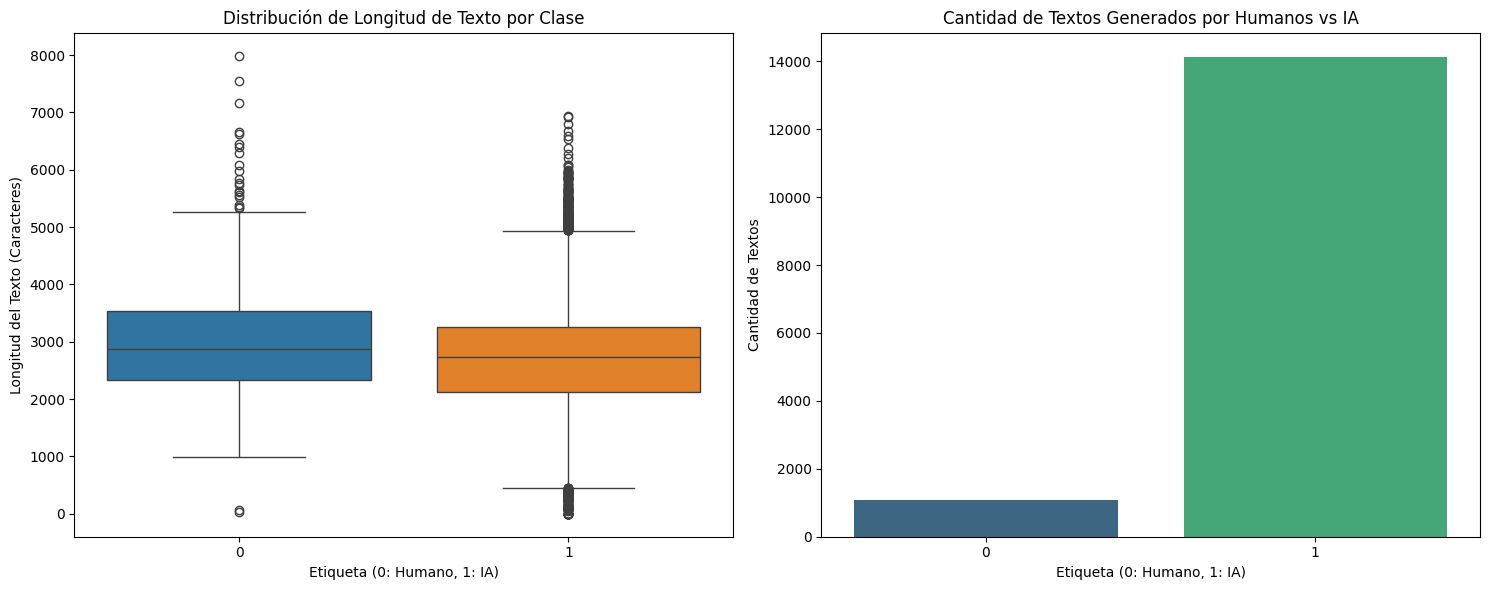

In [95]:
df_human = pd.read_json('data/human.jsonl', lines=True)

df_human_temp = df_human.reset_index(drop=True)
df_human_temp['label'] = 0

df_machine = pd.read_json(machines_files[0], lines=True)
for file in machines_files[1:]:
    df_current = pd.read_json(file, lines=True)
    df_machine = pd.concat([df_machine, df_current])

df_machine_temp = df_machine.reset_index(drop=True)
df_machine_temp['label'] = 1


df_temp = pd.concat([df_human_temp, df_machine_temp], axis=0, ignore_index=True)

# Calcular la longitud del texto en la columna 'text'
df_temp["text_length"] = df_temp["text"].apply(len)

# Crear una figura con 2 subgráficos (uno al lado del otro)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 1. Gráfico de la longitud del texto (sin `palette`)
sns.boxplot(data=df_temp, x="label", hue="label",y="text_length", ax=ax[0], legend=False)
ax[0].set_title("Distribución de Longitud de Texto por Clase")
ax[0].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[0].set_ylabel("Longitud del Texto (Caracteres)")

# 2. Gráfico de la cantidad de texto generado por IA y Humanos
sns.countplot(data=df_temp, x="label", hue="label", palette="viridis", ax=ax[1], legend=False)
ax[1].set_title("Cantidad de Textos Generados por Humanos vs IA")
ax[1].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[1].set_ylabel("Cantidad de Textos")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [96]:
# Concatenar ambos dataframes
df_combined = pd.concat([df_human_temp, df_machine_temp], ignore_index=True)
df_combined_nltk = df_combined.drop(columns=['id'])
df_combined_nltk

,text,label
0,Inaugural Address by President Joseph R. Biden...,0
1,Fact check: Biden inauguration impacted by pan...,0
2,Highlights from Joe Biden's 2021 inauguration\...,0
3,"Biden takes the helm, appeals for unity to tak...",0
4,'The Hill We Climb': Read Amanda Gorman's inau...,0
...,...,...
15213,'The Disappearance of Gabby Petito' – A Compre...,1
15214,"Utah State Police Search for Gabby Petito, Tra...",1
15215,McKenna's Lost Friend: Debunking the Evidence ...,1
15216,"""Gunshots Found in Florida Nature Preserve: A ...",1


In [97]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [99]:
df_combined_nltk['text'] = df_combined_nltk['text'].apply(preprocess_text)
df_combined_nltk

,text,label
0,inaugural address president joseph r biden jr ...,0
1,fact check biden inauguration impacted pandemi...,0
2,highlights joe bidens 2021 inauguration washin...,0
3,biden takes helm appeals unity take crises was...,0
4,hill climb read amanda gormans inaugural poem ...,0
...,...,...
15213,disappearance gabby petito – comprehensive ana...,1
15214,utah state police search gabby petito travelin...,1
15215,mckennas lost friend debunking evidence behind...,1
15216,gunshots found florida nature preserve murder ...,1


In [100]:
X = df_combined_nltk['text']
y = df_combined_nltk['label']

X, y

(0        inaugural address president joseph r biden jr ...
 1        fact check biden inauguration impacted pandemi...
 2        highlights joe bidens 2021 inauguration washin...
 3        biden takes helm appeals unity take crises was...
 4        hill climb read amanda gormans inaugural poem ...
                                ...                        
 15213    disappearance gabby petito – comprehensive ana...
 15214    utah state police search gabby petito travelin...
 15215    mckennas lost friend debunking evidence behind...
 15216    gunshots found florida nature preserve murder ...
 15217    kind sweet woman long island shocked remarkabl...
 Name: text, Length: 15218, dtype: object,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 15213    1
 15214    1
 15215    1
 15216    1
 15217    1
 Name: label, Length: 15218, dtype: int64)

In [101]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)  # Convertir texto en vectores, asignando pesos a las palabras según su importancia en un conjunto de documentos

## Cálculo TF-IDF Vectorizer

### 1. **TF (Term Frequency)**: Frecuencia de una palabra en una muestra.
El cálculo de la frecuencia de un término (TF) es el número de veces que una palabra aparece en una muestra, dividido por el número total de palabras en esa muestra.

$$
\text{TF} = \frac{\text{Número de veces que aparece una palabra en la muestra}}{\text{Número total de palabras en la muestra}}
$$

### 2. **IDF (Inverse Document Frequency)**: Importancia de una palabra inversamente proporcional al número de muestras donde aparece.
El cálculo de IDF refleja la importancia de una palabra, penalizando aquellas que aparecen en muchas muestras, ya que no aportan tanta información. Se calcula como el logaritmo del cociente entre el número total de muestras y el número de muestras donde aparece la palabra.

$$
\text{IDF} = \log \left( \frac{\text{Número total de muestras}}{\text{Número de muestras donde aparece la palabra}} + 1 \right)
$$

### 3. **TF-IDF**: Producto del TF y el IDF.
El TF-IDF es el producto de la frecuencia del término (TF) y su importancia inversa (IDF). Esto da como resultado una medida ponderada que resalta las palabras más relevantes y únicas en un conjunto de muestras.

$$
\text{TF-IDF} = \text{TF} \times \text{IDF}
$$


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

X_train, y_train

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 1668280 stored elements and shape (10652, 40470)>,
 14794    1
 2304     1
 12272    1
 5446     1
 7255     1
         ..
 5191     1
 13418    1
 5390     1
 860      0
 7270     1
 Name: label, Length: 10652, dtype: int64)

In [103]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [104]:
y_pred = model.predict(X_test)  
y_prob = model.predict_proba(X_test)[:, 1]

In [105]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

f05 = (1 + 0.5**2) * (precision * recall) / ((0.5**2) * precision + recall)

test_loss = brier_score_loss(y_test, y_prob)

roc_auc = roc_auc_score(y_test, y_prob)

def calculate_c_at_1(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    abstained = 0  
    total = len(y_true)
    c_at_1 = (correct_predictions + abstained / 2) / total
    return c_at_1

c_at_1 = calculate_c_at_1(y_test, y_pred)


print(f"Test Loss (Brier Score): {test_loss:.4f}")
print(f"Test Accuracy: {np.mean(y_test == y_pred):.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"C@1: {c_at_1:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F0.5 Score: {f05:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Test Loss (Brier Score): 0.0708
Test Accuracy: 0.9288
ROC-AUC: 0.7438
C@1: 0.9288
F1 Score: 0.9631
F0.5 Score: 0.9424
Precision: 0.9290
Recall: 0.9998
